In [1]:
!pip install pybullet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.6 MB/s eta 0:00:00


In [2]:
#you can enable the GPU by changing the runtime
import os
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '330'
import pybullet as p
import pybullet_data as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pylab
from google.colab import widgets
import random
import time

p.connect(p.DIRECT)
#allow to find the assets (URDF, obj, textures etc)
p.setAdditionalSearchPath(pd.getDataPath())

#optionally enable GPU for faster rendering in pybullet.getCameraImage
enableGPU = False
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
import sys
# Get all device ids and their processing and memory utiliazion
# (deviceIds, gpuUtil, memUtil) = GPU.getGPUs()

# Print os and python version information
print('OS: ' + sys.platform)
print(sys.version)

# Print package name and version number
print(GPU.__name__ + ' ' + GPU.__version__)

# Show the utilization of all GPUs in a nice table
GPU.showUtilization()

# Show all stats of all GPUs in a nice table
GPU.showUtilization(all=True)

# NOTE: If all your GPUs currently have a memory consumption larger than 1%,
# this step will fail. It's not a bug! It is intended to do so, if it does not
# find an available GPU.
GPUs = GPU.getGPUs()
numGPUs = len(GPU.getGPUs())
print("numGPUs=",numGPUs)
if numGPUs > 0:
  enableGPU = True
eglPluginId = -1
if enableGPU:
  import pkgutil
  egl = pkgutil.get_loader('eglRenderer')
  if (egl):
    eglPluginId = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
  else:
    eglPluginId = p.loadPlugin("eglRendererPlugin")

if eglPluginId>=0:
  print("Using GPU hardware (eglRenderer)")
else:
  print("using CPU renderer (TinyRenderer)")

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=f87fbc4f42c835358306c5e3c74fae6d4f96c713d735101860dade7d6368053a
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
OS: linux
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
GPUtil 1.4.0
| ID | GPU | MEM |
------------------
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------
numGPUs= 0
using CPU renderer (TinyRenderer)


In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 960, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 960 (delta 319), reused 244 (delta 178), pack-reused 557 (from 1)
Receiving objects: 100% (960/960), 8.52 MiB | 10.89 MiB/s, done.
Resolving deltas: 100% (632/632), done.
/content/Real_Mega_Fufi/Robot/1LegTrail


In [4]:
#using FEM
p.resetSimulation(p.RESET_USE_DEFORMABLE_WORLD)
p.setTimeStep(0.01)
p.configureDebugVisualizer(p.COV_ENABLE_GUI)
#tell him to slide freely on the ground plane
useFixedBase = True
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=useFixedBase)


🛑 🛑 **SUPER IMPORTANT TO KEEP IN MIND** 🛑 🛑
obj file and pybullet DO NOT HAVE the same reference system. In order to set it right when exporting the model in .obj from blender, gotta change up axis to z. It can be be done with File-> export .obj -> see on the right panel up.

In [8]:
elastic_joint_id = p.loadSoftBody("single_elastic_joint.obj", \
                                  mass=0.0569, \
                                  useNeoHookean=1, \
                                  NeoHookeanMu=76.92,\
                                  NeoHookeanLambda=115.38, \
                                  NeoHookeanDamping=0.01,\
                                  collisionMargin=0.005,\
                                  useSelfCollision=0,\
                                  frictionCoeff=0.5)
#arancione
p.changeVisualShape(elastic_joint_id, -1, rgbaColor=[1, 0.65, 0, 1])

🛑 🛑 **ALSO PRETTY IMPORTANT** 🛑 🛑

```
p.loadURDF("pippa_oneleg_column.urdf", \
                       basePosition = column_position, \
                       baseOrientation =column_orientation , \
                       useFixedBase=useFixedBase)

```
basePosition = coordinate del centro di massa, quindi se questo sta in 0,0 bisogna che a z tu ci metta le coordinate della metà dell'altezza dell'oggetto.


In [9]:
#get column
joint_x, joint_y, joint_z = p.getBasePositionAndOrientation(elastic_joint_id)[0]
column_position = [joint_x, joint_y, 0.1]
column_orientation = p.getQuaternionFromEuler([0,0,0])

column_id = p.loadURDF("pippa_oneleg_column.urdf", \
                       basePosition = column_position, \
                       baseOrientation =column_orientation , \
                       useFixedBase=useFixedBase)
# verdino
p.changeVisualShape(column_id, -1, rgbaColor=[0.5, 1, 0.5, 1])

#get leg
leg_position = [joint_x,joint_y,0.6175]
leg_orientation = p.getQuaternionFromEuler([0,0,0])
leg_id = p.loadURDF("pippa_oneleg_leg.urdf", \
                       basePosition = leg_position, \
                       baseOrientation = leg_orientation )
# azzurrino
p.changeVisualShape(leg_id, -1, rgbaColor=[0.5, 0.8, 1, 1])


Per ancorare bisogna capire quali sono i punti da ancorare, quindi mi stampo i nodi.

Sintassi delle funzioni 📚

1. get nodes info : `num_nodes, nodes_positions = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)`
2. anchoring:  `p.createSoftBodyAnchor(softBodyUniqueId, nodeIndex, bodyUniqueId, linkIndex, positionOffset=None)`






In [10]:
# Recupera le posizioni dei nodi del soft body
mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)

# Check se i dati della mesh sono disponibili
if mesh_data:
    num_nodes = mesh_data[0]  # Numero di nodi
    node_positions = mesh_data[1]  # Posizioni dei nodi

    # Trova il valore medio della coordinata z per separare i nodi superiori e inferiori
    z_values = [pos[2] for pos in node_positions]
    print(f'z_values', z_values)
    threshold_z = (min(z_values) + max(z_values)) / 2  # Soglia centrale
    print(f'threshold_z', threshold_z)

    # Ancoraggio dei nodi
    for node_index, node_pos in enumerate(node_positions):
        if node_pos[2] >= threshold_z:
            # Nodo superiore: ancora alla gamba
            p.createSoftBodyAnchor(elastic_joint_id, node_index, leg_id, -1)
        else:
            # Nodo inferiore: ancora alla colonna
            p.createSoftBodyAnchor(elastic_joint_id, node_index, column_id, -1)
else:
    print("Errore: I dati della mesh non sono stati recuperati correttamente.")


z_values [0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.20000000298023224, 0.2800000011920929, 0.2000

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

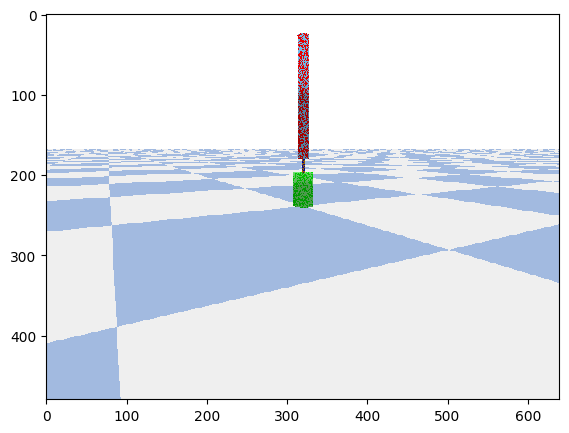

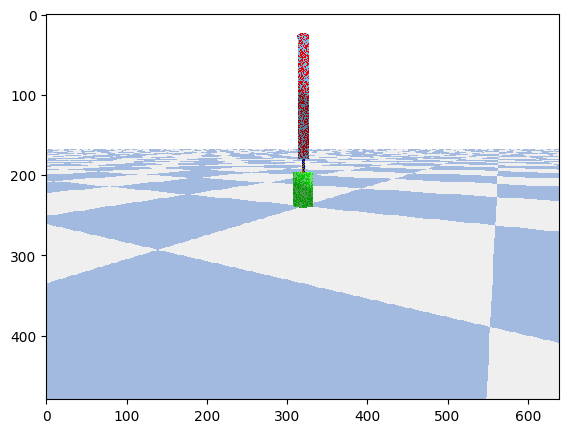

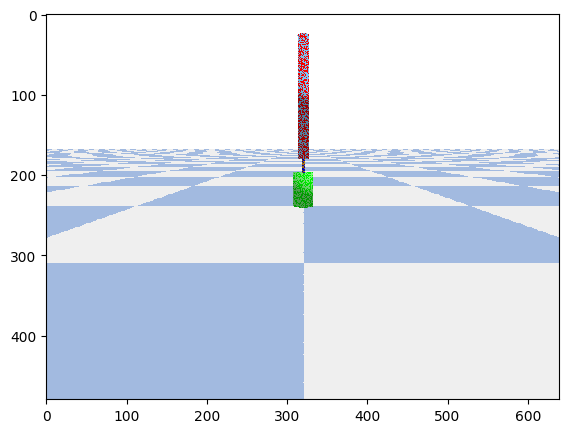

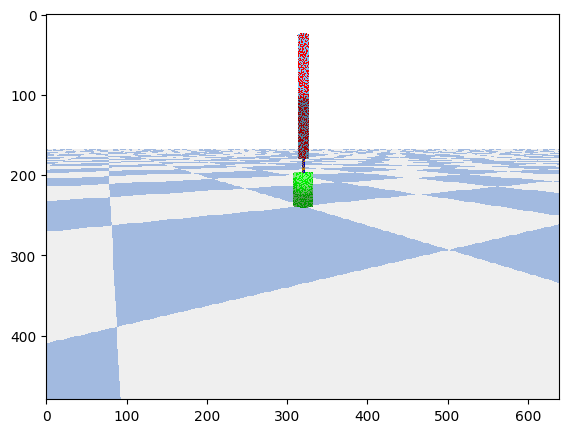

In [11]:
# Parametri della telecamera
camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
p.setGravity(0, 0, -9.81)

# Visualizzazione 3D della scena con telecamera in più angolazioni
grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
    for c in range(2):
        yaw += 60
        with grid.output_to(r, c):
            grid.clear_cell()
            plt.figure(figsize=(10, 5))
            pitch = -10.0
            roll = 0
            upAxisIndex = 2
            camDistance = 2
            pixelWidth = 640
            pixelHeight = 480
            nearPlane = 0.01
            farPlane = 100
            fov = 60
            viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch, roll, upAxisIndex)
            aspect = pixelWidth / pixelHeight
            projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

            img_arr = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix, projectionMatrix)
            w = img_arr[0]  # width of the image, in pixels
            h = img_arr[1]  # height of the image, in pixels
            rgb = img_arr[2]  # color data RGB
            np_img_arr = np.reshape(rgb, (h, w, 4))
            np_img_arr = np_img_arr * (1. / 255.)
            plt.imshow(np_img_arr, interpolation='none', animated=True)

In [ ]:
p.disconnect()